In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

In [2]:
# Версии библиотек
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

PyTorch: 2.9.0+cu128
Torchvision: 0.24.0+cu128
NumPy: 2.3.4
Matplotlib: 3.10.7


## Установка Seed

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Аугментация данных

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_ds  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=0)

## Модель (тот же энкодер, что и в BYOL) + Линейная голова

In [5]:
class Encoder(nn.Module):
    def __init__(self, rep_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
        )
        self.fc = nn.Linear(128, rep_dim)
    def forward(self, x): return self.fc(self.net(x))

class SupervisedModel(nn.Module):
    def __init__(self, rep_dim=128, num_classes=10):
        super().__init__()
        self.encoder = Encoder(rep_dim)
        self.classifier = nn.Linear(rep_dim, num_classes)
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

## Функция обучения

In [6]:
def train_supervised(model, train_loader, test_loader, device, epochs=10, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_accs = []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        acc = evaluate_accuracy(model, test_loader, device)
        train_losses.append(avg_loss)
        test_accs.append(acc)
        print(f"Epoch {epoch}: loss={avg_loss:.4f}, test_acc={acc:.2f}%")
    return train_losses, test_accs

def evaluate_accuracy(model, test_loader, device):
    # Оценка точности 
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

# Матрица ошибок

In [7]:
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Матрица ошибок — Supervised")
    plt.show()

## Параметры

In [9]:
model = SupervisedModel(rep_dim=128, num_classes=10)
epochs = 50
lr = 1e-3

## Обучение

In [10]:
train_losses, test_accs = train_supervised(model, train_loader, test_loader, device, epochs=epochs, lr=lr)

Epoch 1/50: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]


Epoch 1: loss=0.3122, test_acc=84.33%


Epoch 2/50: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]


Epoch 2: loss=0.0707, test_acc=86.05%


Epoch 3/50: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]


Epoch 3: loss=0.0493, test_acc=96.66%


Epoch 4/50: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]


Epoch 4: loss=0.0408, test_acc=97.48%


Epoch 5/50: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]


Epoch 5: loss=0.0330, test_acc=98.12%


Epoch 6/50: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]


Epoch 6: loss=0.0262, test_acc=94.62%


Epoch 7/50: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]


Epoch 7: loss=0.0226, test_acc=98.44%


Epoch 8/50: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]


Epoch 8: loss=0.0215, test_acc=98.41%


Epoch 9/50: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]


Epoch 9: loss=0.0202, test_acc=96.89%


Epoch 10/50: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]


Epoch 10: loss=0.0144, test_acc=98.67%


Epoch 11/50: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]


Epoch 11: loss=0.0153, test_acc=97.25%


Epoch 12/50: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]


Epoch 12: loss=0.0131, test_acc=98.65%


Epoch 13/50: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]


Epoch 13: loss=0.0141, test_acc=98.62%


Epoch 14/50: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]


Epoch 14: loss=0.0107, test_acc=98.98%


Epoch 15/50: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]


Epoch 15: loss=0.0099, test_acc=98.95%


Epoch 16/50: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]


Epoch 16: loss=0.0078, test_acc=97.82%


Epoch 17/50: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]


Epoch 17: loss=0.0103, test_acc=98.49%


Epoch 18/50: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]


Epoch 18: loss=0.0077, test_acc=96.90%


Epoch 19/50: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]


Epoch 19: loss=0.0071, test_acc=98.90%


Epoch 20/50: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]


Epoch 20: loss=0.0090, test_acc=98.91%


Epoch 21/50: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]


Epoch 21: loss=0.0062, test_acc=98.18%


Epoch 22/50: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]


Epoch 22: loss=0.0090, test_acc=98.84%


Epoch 23/50: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]


Epoch 23: loss=0.0054, test_acc=98.24%


Epoch 24/50: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]


Epoch 24: loss=0.0068, test_acc=98.57%


Epoch 25/50: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]


Epoch 25: loss=0.0048, test_acc=97.13%


Epoch 26/50: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]


Epoch 26: loss=0.0045, test_acc=97.69%


Epoch 27/50: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]


Epoch 27: loss=0.0083, test_acc=98.90%


Epoch 28/50: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]


Epoch 28: loss=0.0046, test_acc=98.06%


Epoch 29/50: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]


Epoch 29: loss=0.0040, test_acc=98.92%


Epoch 30/50: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Epoch 30: loss=0.0051, test_acc=98.83%


Epoch 31/50: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


Epoch 31: loss=0.0054, test_acc=98.97%


Epoch 32/50: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]


Epoch 32: loss=0.0045, test_acc=98.76%


Epoch 33/50: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]


Epoch 33: loss=0.0036, test_acc=98.25%


Epoch 34/50: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]


Epoch 34: loss=0.0030, test_acc=97.73%


Epoch 35/50: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]


Epoch 35: loss=0.0049, test_acc=98.76%


Epoch 36/50: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]


Epoch 36: loss=0.0043, test_acc=98.93%


Epoch 37/50: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]


Epoch 37: loss=0.0026, test_acc=97.99%


Epoch 38/50: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]


Epoch 38: loss=0.0046, test_acc=98.86%


Epoch 39/50: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]


Epoch 39: loss=0.0024, test_acc=99.11%


Epoch 40/50: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]


Epoch 40: loss=0.0009, test_acc=98.80%


Epoch 41/50: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]


Epoch 41: loss=0.0087, test_acc=98.79%


Epoch 42/50: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]


Epoch 42: loss=0.0028, test_acc=99.03%


Epoch 43/50: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Epoch 43: loss=0.0015, test_acc=99.11%


Epoch 44/50: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Epoch 44: loss=0.0058, test_acc=98.90%


Epoch 45/50: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]


Epoch 45: loss=0.0017, test_acc=99.16%


Epoch 46/50: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]


Epoch 46: loss=0.0030, test_acc=98.84%


Epoch 47/50: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]


Epoch 47: loss=0.0032, test_acc=98.79%


Epoch 48/50: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]


Epoch 48: loss=0.0017, test_acc=99.12%


Epoch 49/50: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Epoch 49: loss=0.0015, test_acc=99.16%


Epoch 50/50: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]


Epoch 50: loss=0.0009, test_acc=99.39%


## Графики

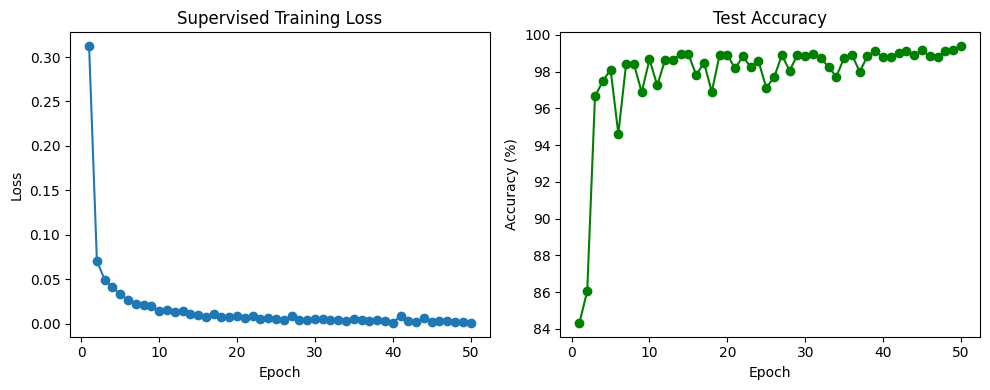

In [11]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Supervised Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, len(test_accs)+1), test_accs, marker='o', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

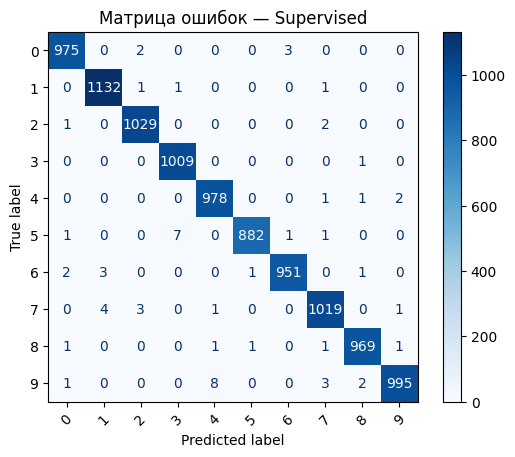

In [12]:
# Матрица ошибок
plot_confusion_matrix(model, test_loader, device)